In [1]:
from lib import *
from tqdm.notebook import tqdm
import matplotlib

In [2]:
def calculate_delta_ex_N_dependency(N_arr, delta_op, create_phi=create_coherent_phi):
    delta_expectations = np.empty(len(N_arr), dtype=np.complex128)

    for i, N in enumerate(N_arr):
        phi = create_phi(N)
        delta_expectations[i] = delta_op.expval(phi)

    return delta_expectations

  0%|          | 0/4 [00:00<?, ?it/s]

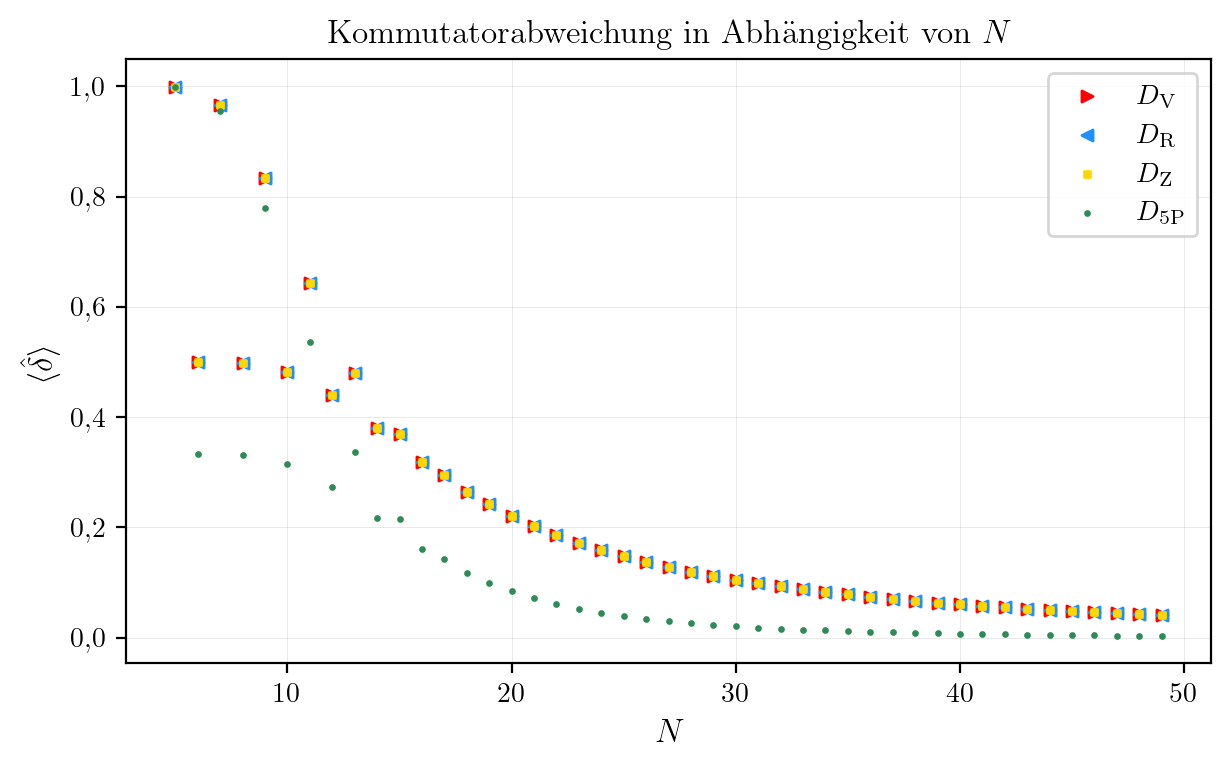

In [3]:
D_method_kwargs = {
    "V": dict(marker=">", s=16, zorder=1, color="red"),
    "R": dict(marker="<", s=16, zorder=1, color="dodgerblue"),
    "Z": dict(marker="s", s=6, zorder=2, color="gold"),
    "5P": dict(marker="o", s=2, zorder=3, color="seagreen"),
}

def analyze_delta_ex_N_dependency():
    N_arr = np.arange(5, 50, dtype=np.int32)

    for D_method in (tqdm(D_methods)):
        delta_op = create_delta_op(D_method)
        delta_expectations = calculate_delta_ex_N_dependency(N_arr, delta_op)

        plt.scatter(N_arr, delta_expectations.real, label="$D_\\mathrm{" + D_method + "}$", **D_method_kwargs[D_method])

    plt.title("Kommutatorabweichung in Abhängigkeit von $N$")
    plt.legend()

    plt.xlabel("$N$")
    plt.ylabel("$\\langle \\hat \\delta \\rangle$")

analyze_delta_ex_N_dependency()

In [4]:
def calc_chi_squ_dof(x, y, params):
    dof = len(x) - len(params)
    chi_sq = np.sum((np.polyval(params, x) - y) ** 2)
    return chi_sq / dof

def analyze_delta_ex_N_dependency_log(create_phi=create_coherent_phi, plot=True, progress=True, max_N=1000, fit=True, parts=[np.abs], filename=None, R=1):
    if plot:
        # plt.title(f"$N = {max_N}$")
        plot_phi(create_phi(max_N))
        plt.show()


    N_arr = np.logspace(.6, np.log10(max_N), 50, dtype=int)
    dx_arr = np.array([calc_dx(N) for N in N_arr]).real

    min_linear_N = 100
    linear_N = N_arr > min_linear_N
    max_linear_dx = dx_arr[linear_N].max()

    fit_params = {}

    # parts = [np.abs, np.real, np.imag]
    # parts = [np.abs]

    if plot:
        fig, axes = plt.subplots(len(parts), 1, figsize=(7, 4 * len(parts)), sharex=True, squeeze=False)
    else:
        axes = np.empty((1, len(parts)))

    for ax, part in zip(axes[0,:], parts):
        for D_method in (tqdm(D_methods) if progress else D_methods):
            delta_op = create_delta_op(D_method, R=R)
            delta_expectations = calculate_delta_ex_N_dependency(N_arr, delta_op, create_phi)

            if (delta_expectations == 0).any():
                print("Found zero value for", D_method)
                if fit: fit_params[D_method] = (np.nan, np.nan)
                continue
            
            if fit:
                fit_x = np.log(dx_arr[linear_N])
                fit_y = np.log(part(delta_expectations)[linear_N])
                (alpha, beta), cov = np.polyfit(fit_x, fit_y, 1, cov=True)
                (alpha_err, beta_err) = np.sqrt(np.diag(cov))

                if plot:
                    print("chi_sq/dof =", calc_chi_squ_dof(fit_x, fit_y, (alpha, beta)))
            
                fit_params[D_method] = ((alpha, alpha_err), (beta, beta_err))
            
            if plot:
                kwargs = D_method_kwargs[D_method]
                ax.scatter(dx_arr, part(delta_expectations), label="$\\hat\\delta_\\mathrm{" + D_method + "}$", **kwargs)
                if fit:
                    ax.plot(dx_arr, np.exp(beta) * dx_arr ** alpha, color=kwargs["color"], zorder=kwargs["zorder"], alpha=.5)


        if plot:
            if fit:
                ax.axvspan(dx_arr.min(), max_linear_dx, color="k", alpha=.05, zorder=-1)
                ax.text(dx_arr.min() * 1.1, 2, "Fit-Region", color="k")

            ax.set_ylabel("$|\\langle \\hat \\delta_A \\rangle|$")
            ax.set_yscale("log")
            # ax.set_ylim(1e-8, 1e1)
            ax.legend()

        if fit and plot:
            print(f"Fit params ({part.__name__}):")
            for D_method, (alpha, beta) in fit_params.items():
                print(f"  D_{D_method}:  alpha = {fmt(alpha, 5)},  beta = {fmt(beta, 4)}")

    if plot:
        axes[0,-1].set_xlabel("$\\Delta x$")
        axes[0,-1].set_xscale("log")
        if filename:
            plt.savefig(f"output/{filename}.pdf", bbox_inches="tight")
        plt.show()

    return fit_params if fit else None


# $p = 0$

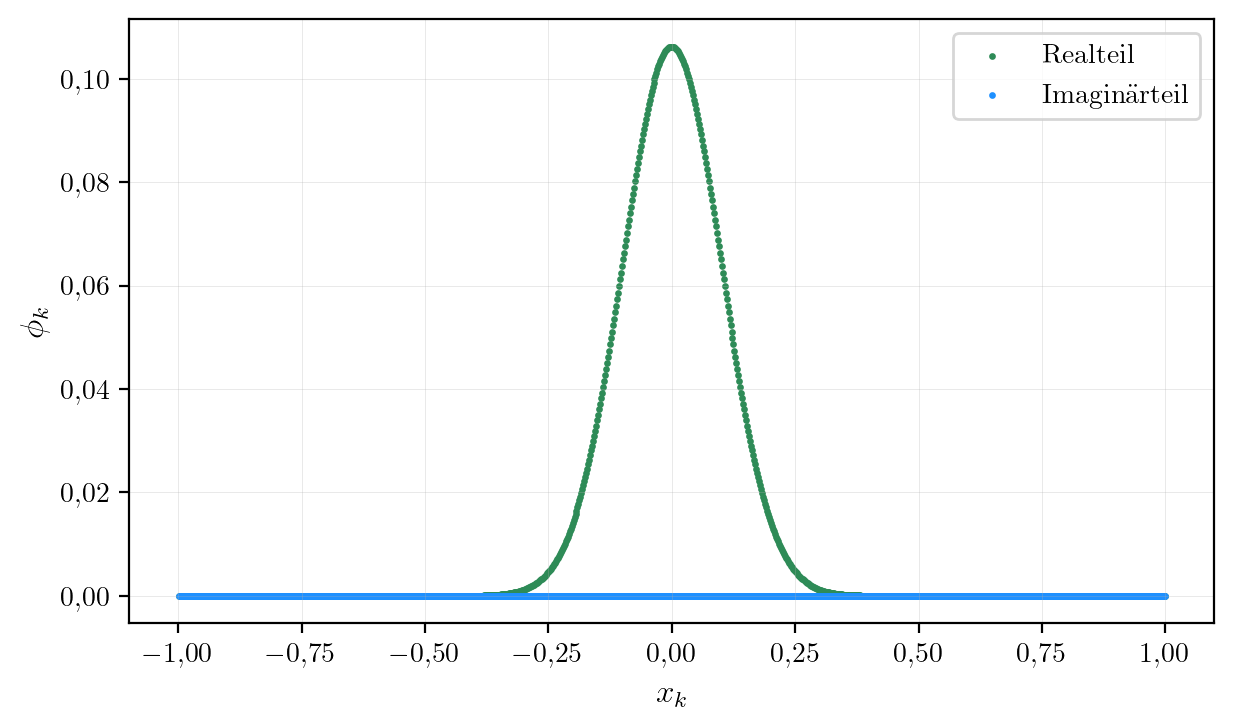

  0%|          | 0/4 [00:00<?, ?it/s]

chi_sq/dof = 4.371899591098931e-07
chi_sq/dof = 4.371899591160816e-07
chi_sq/dof = 4.3718995908368365e-07
chi_sq/dof = 4.842770551309719e-06
Fit params (absolute):
  D_V:  alpha = 1,99839 +/- 0,00022,  beta = 3,2096 +/- 0,0011
  D_R:  alpha = 1,99839 +/- 0,00022,  beta = 3,2096 +/- 0,0011
  D_Z:  alpha = 1,99839 +/- 0,00022,  beta = 3,2096 +/- 0,0011
  D_5P:  alpha = 3,99462 +/- 0,00071,  beta = 7,1000 +/- 0,0037


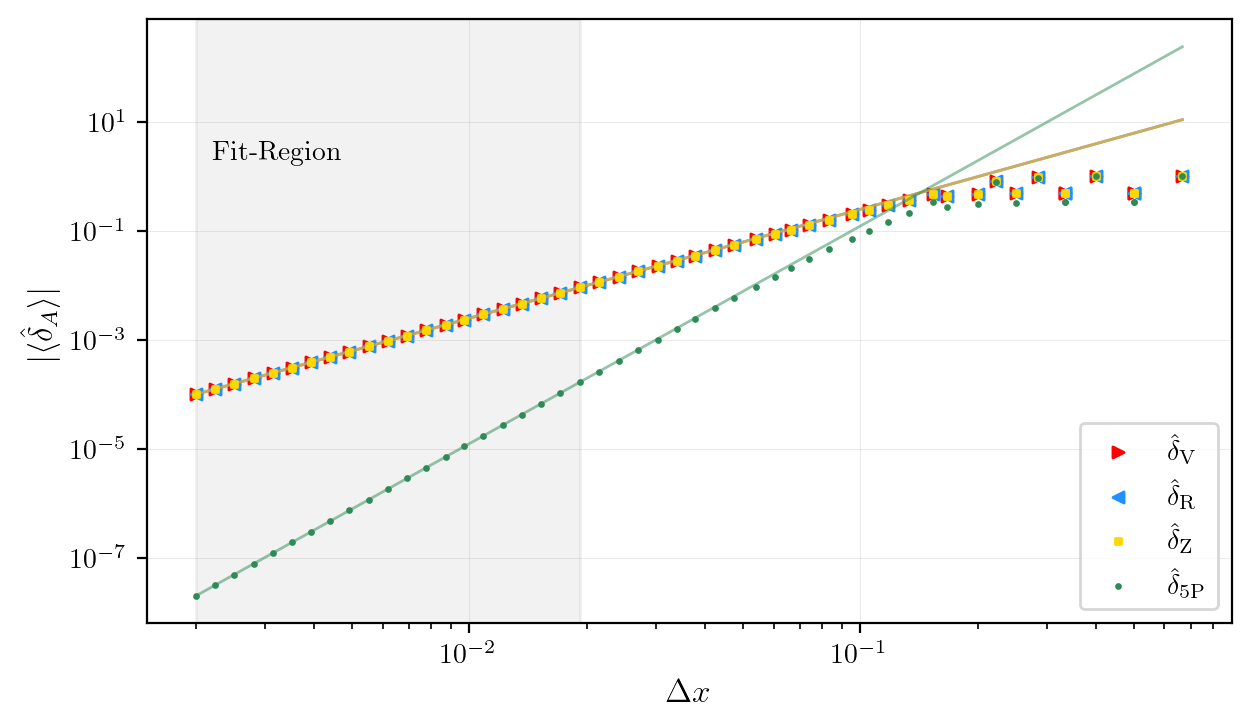

In [5]:
analyze_delta_ex_N_dependency_log(create_phi=lambda N: create_coherent_phi(N, p=0), filename="delta_ex_N_dependency_p0", R=1);

# $p = 10$

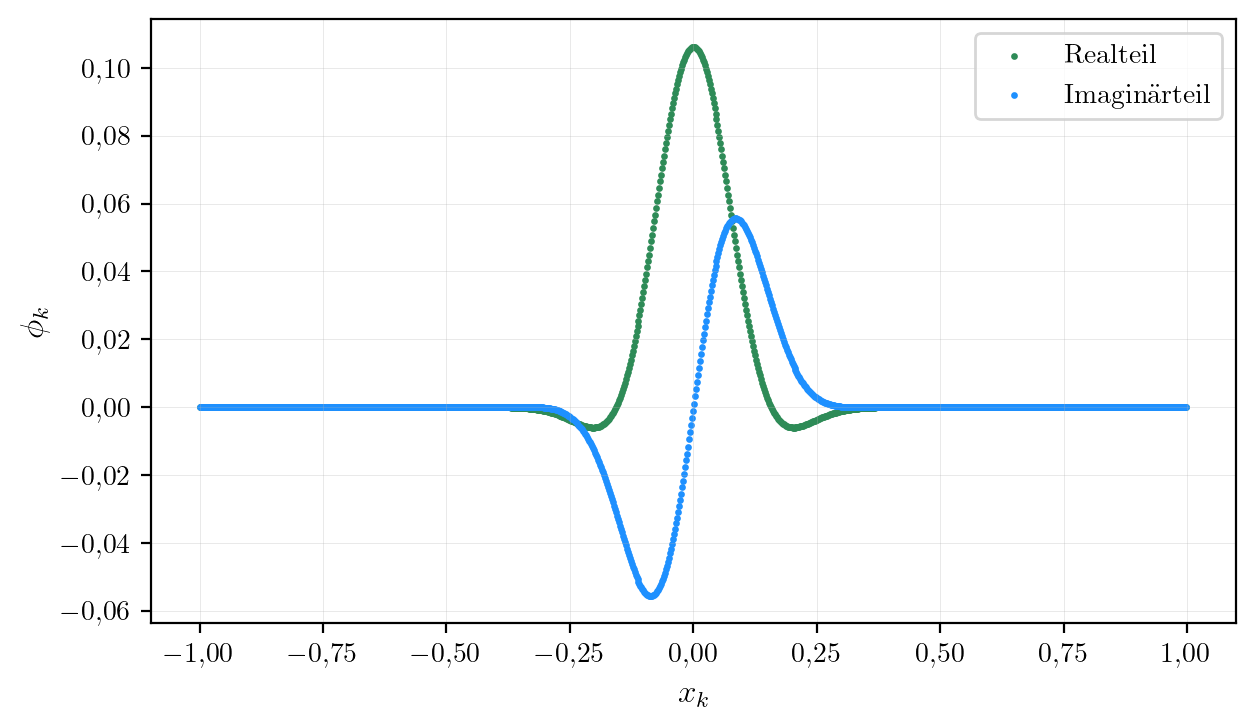

  0%|          | 0/4 [00:00<?, ?it/s]

chi_sq/dof = 5.136273867781706e-07
chi_sq/dof = 5.136273867778175e-07
chi_sq/dof = 1.948641370618688e-06
chi_sq/dof = 1.605163438712975e-05
Fit params (absolute):
  D_V:  alpha = 0,99825 +/- 0,00023,  beta = 2,2925 +/- 0,0012
  D_R:  alpha = 0,99825 +/- 0,00023,  beta = 2,2925 +/- 0,0012
  D_Z:  alpha = 1,99659 +/- 0,00045,  beta = 4,2979 +/- 0,0023
  D_5P:  alpha = 3,99021 +/- 0,00128,  beta = 8,9205 +/- 0,0066


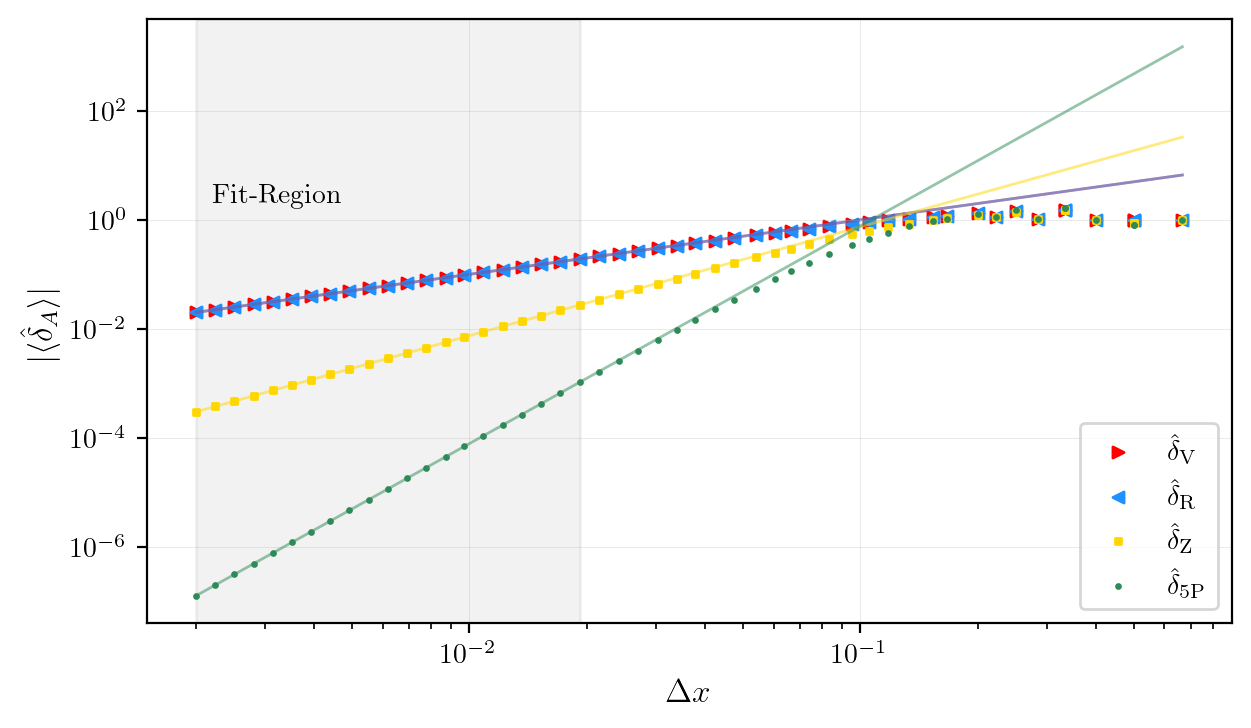

In [6]:
analyze_delta_ex_N_dependency_log(create_phi=lambda N: create_coherent_phi(N, p=10), filename="delta_ex_N_dependency_p10");

In [7]:
# analyze_delta_ex_N_dependency_log(create_phi=lambda N: 1j * create_coherent_phi(N, p=0).conj(), filename="delta_ex_N_dependency_p100");

WEIRD

# $p$-Dependency

  0%|          | 0/50 [00:00<?, ?it/s]

0.3031326059667546 0.3539807065967159


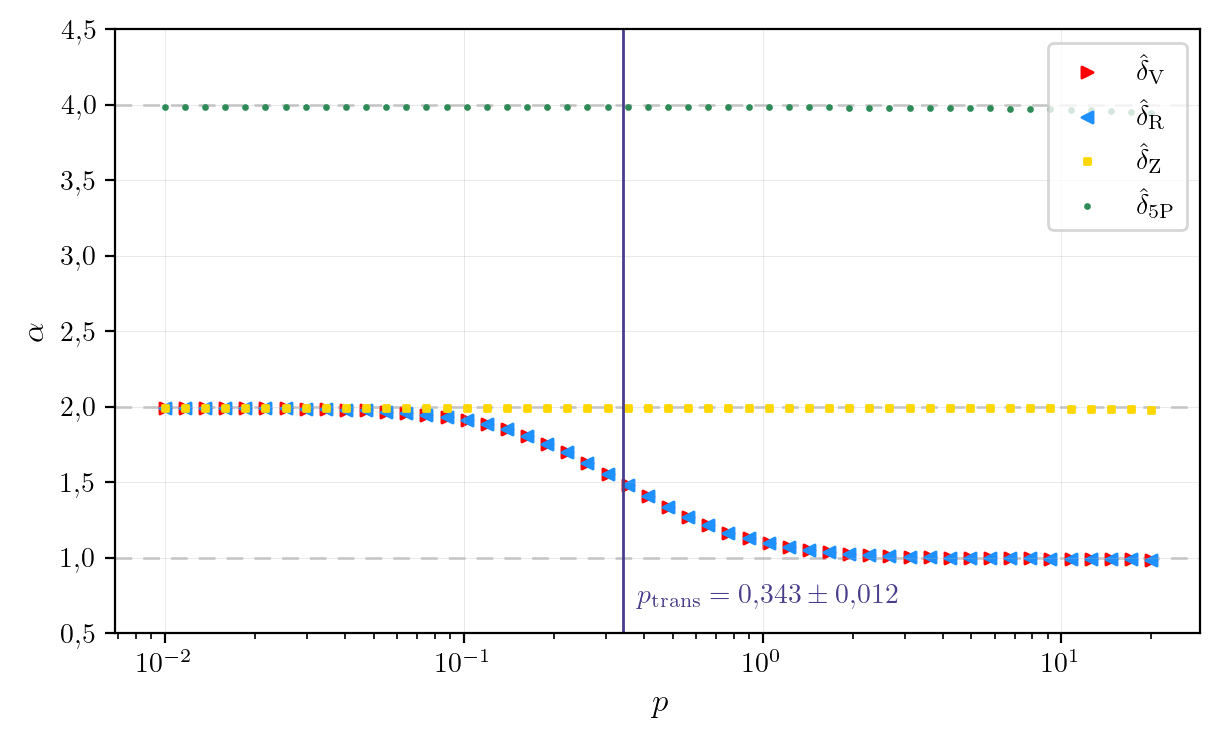

In [8]:
def find_p_trans(p_arr, alpha_arr, alpha_trans=1.5, div=100):
    i_lower = np.argwhere(alpha_arr <= alpha_trans)[0]
    if len(i_lower) > 0:
        i1 = i_lower[0]
        i0 = i1 - 1
        p0 = p_arr[i0]
        p1 = p_arr[i1]
        print(p0, p1)
        alpha0 = alpha_arr[i0]
        alpha1 = alpha_arr[i1]
        m = (alpha1 - alpha0) / (p1 - p0)

        p_interp = np.logspace(np.log10(p0), np.log10(p1), div)
        alpha_interp = alpha0 + m * (p_interp - p0)

        p_trans = p_interp[alpha_interp <= alpha_trans][0]
        err = np.abs(p_arr - p_trans).min()
        return p_trans, err
    else:
        return np.nan, np.nan

def analyze_delta_ex_order_p_dependency(omega=100, sign=1, part=np.abs, q=0, R=1):
    p_arr = sign * np.logspace(-2, 1.3, 50)

    alphas_dict = {method: [] for method in D_methods}
    alpha_errs_dict = {method: [] for method in D_methods}
    
    for p in tqdm(p_arr):
        fit_params = analyze_delta_ex_N_dependency_log(max_N=200, plot=False, progress=False,
            create_phi=lambda N: create_coherent_phi(N, p=p, omega=omega, q=q), parts=[part], R=R)

        for method, ((alpha, alpha_err), _) in fit_params.items():
            alphas_dict[method].append(alpha)
            alpha_errs_dict[method].append(alpha_err)

    alphas_dict = {method: np.array(alphas) for method, alphas in alphas_dict.items()}
    alpha_errs_dict = {method: np.array(alpha_errs) for method, alpha_errs in alpha_errs_dict.items()}

    for method in D_methods:
        alphas = alphas_dict[method]
        plt.scatter(p_arr, alphas, label="$\\hat\\delta_\\mathrm{" + method + "}$", **D_method_kwargs[method])

    p_trans, p_trans_err = find_p_trans(p_arr, alphas_dict["V"])
    plt.axvline(p_trans, color="darkslateblue")
    plt.text(p_trans * 1.1, .7, "$p_\\mathrm{trans} = " + fmt_tex(p_trans, "%.3f") + " \\pm " + fmt_tex(round_up(p_trans_err, 3), "%.3f") + "$", color="darkslateblue")

    for expected_order in [1, 2, 4]:
        plt.axhline(expected_order, color="k", linestyle="--", zorder=0, alpha=.2)

    plt.xlabel("$p$")
    plt.xscale("log")
    plt.ylabel("$\\alpha$")
    # plt.yticks([-4, -2, -1, 0, 2, 4])
    plt.ylim(0.5, 4.5)
    plt.legend(loc="upper right")
    plt.savefig(f"output/delta_ex_order_p_dependency_omega{omega}.pdf", bbox_inches="tight")
    plt.show()


analyze_delta_ex_order_p_dependency()

  0%|          | 0/50 [00:00<?, ?it/s]

1.4292297275398358 1.6689717268457367


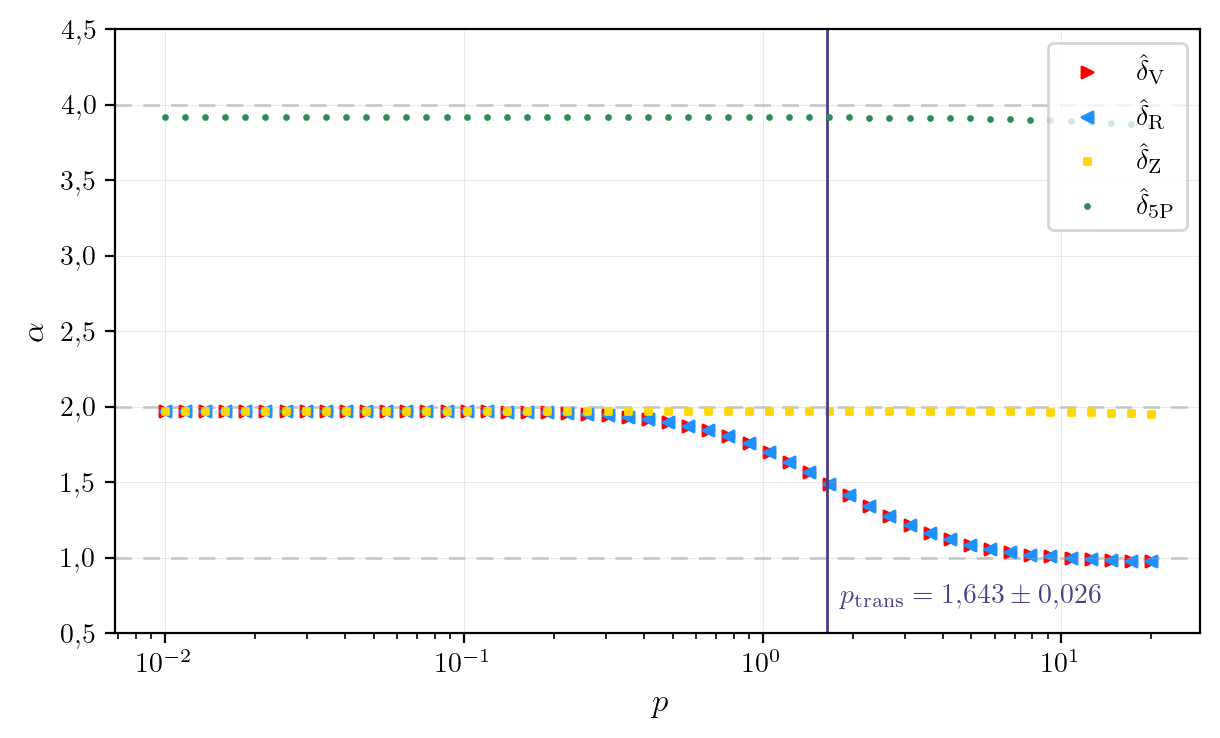

In [9]:
analyze_delta_ex_order_p_dependency(omega=500)

In [10]:
# analyze_delta_ex_order_p_dependency(omega=50)

In [11]:
# analyze_delta_ex_order_p_dependency(part=np.real)

In [12]:
# analyze_delta_ex_order_p_dependency(part=np.imag)

  0%|          | 0/20 [00:00<?, ?it/s]

0.18587918911465637 0.22586355207213757
0.2744489278096424 0.3334854751235185
0.4052213393797471 0.49238826317067363
0.49238826317067363 0.5983056126297137
0.5983056126297137 0.7270067807853818
0.7270067807853818 0.8833927814664049
0.7270067807853818 0.8833927814664049
0.8833927814664049 1.0734188827013527
0.8833927814664049 1.0734188827013527
1.0734188827013527 1.304321386719004
1.0734188827013527 1.304321386719004
1.304321386719004 1.5848931924611125
1.304321386719004 1.5848931924611125
1.304321386719004 1.5848931924611125
1.5848931924611125 1.9258186341850763
1.5848931924611125 1.9258186341850763
1.5848931924611125 1.9258186341850763
1.5848931924611125 1.9258186341850763
1.9258186341850763 2.3400803470013445
1.9258186341850763 2.3400803470013445
m = 0,004226 +/- 0,000040
b = 0,013253 +/- 0,003588
chi²/dof = 0.0003593926701186681


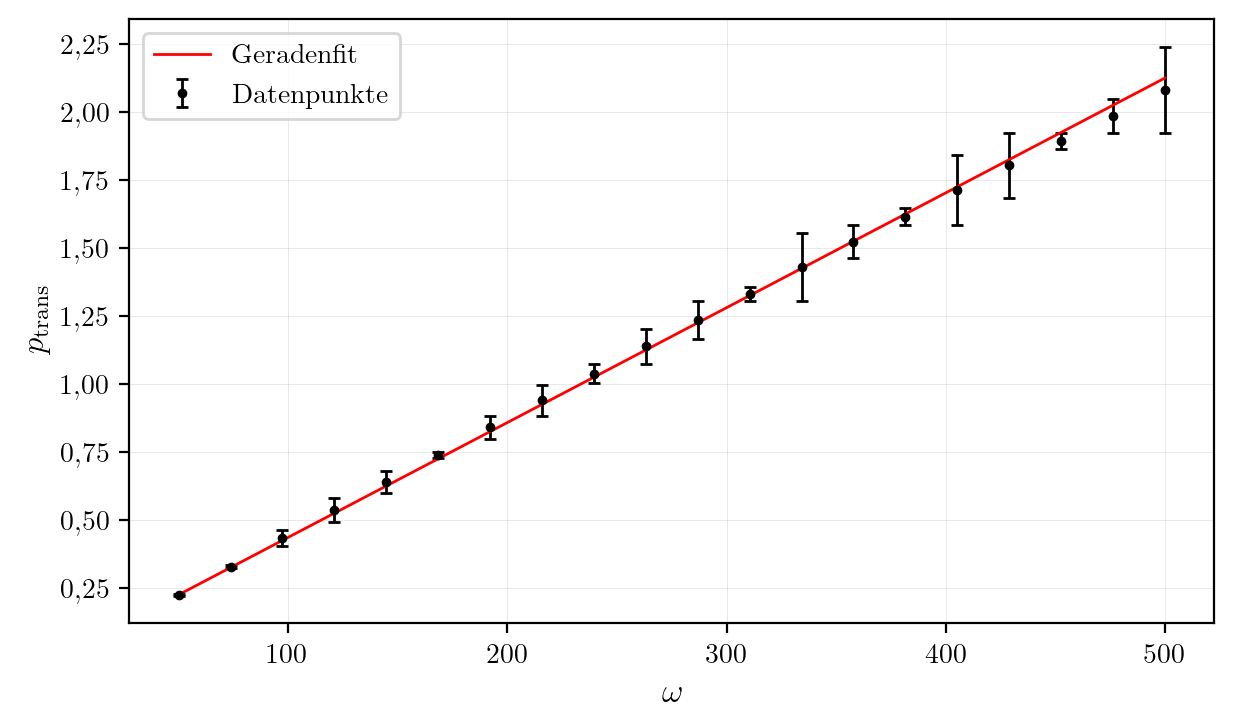

In [13]:
def analyze_p_trans_omega_dependency(part=np.abs, q=0, R=1):
    omega_arr = np.linspace(50, 500, 20)
    p_arr = np.logspace(-2, 1.3, 40)

    p_trans_vals = []
    p_trans_errs = []

    for omega in tqdm(omega_arr):
        alphas = []
        
        for p in p_arr:
            fit_params = analyze_delta_ex_N_dependency_log(max_N=120, plot=False, progress=False,
                create_phi=lambda N: create_coherent_phi(N, p=p, omega=omega, q=q), parts=[part], R=R)

            alphas.append(fit_params["V"][0][0])
        alpha_arr = np.array(alphas)

        p_trans, p_trans_err = find_p_trans(p_arr, alpha_arr)
        p_trans_vals.append(p_trans)
        p_trans_errs.append(p_trans_err)

    p_trans_arr = np.array(p_trans_vals)
    p_trans_err_arr = np.array(p_trans_errs)

    plt.errorbar(omega_arr, p_trans_arr, yerr=p_trans_err_arr, fmt=".", markersize=5, capsize=2, c="k", label="Datenpunkte")

    (m, b), cov = np.polyfit(omega_arr, p_trans_arr, 1, w=1/p_trans_err_arr, cov='unscaled')
    (m_err, b_err) = np.sqrt(np.diag(cov))
    chi_squ = calc_chi_squ_dof(omega_arr, p_trans_arr, (m, b))
    
    print(f"m = {fmt((m, m_err), 6)}")
    print(f"b = {fmt((b, b_err), 6)}")
    print(f"chi²/dof = {chi_squ}")

    plt.plot(omega_arr, m * omega_arr + b, c="r", label="Geradenfit")

    plt.legend()
    plt.xlabel("$\\omega$")
    plt.ylabel("$p_\\mathrm{trans}$")
    plt.savefig(f"output/p_trans_omega_dependency.pdf", bbox_inches="tight")
    plt.show()

analyze_p_trans_omega_dependency()

### Für $\omega = 2$ (kein linearer Verlauf)

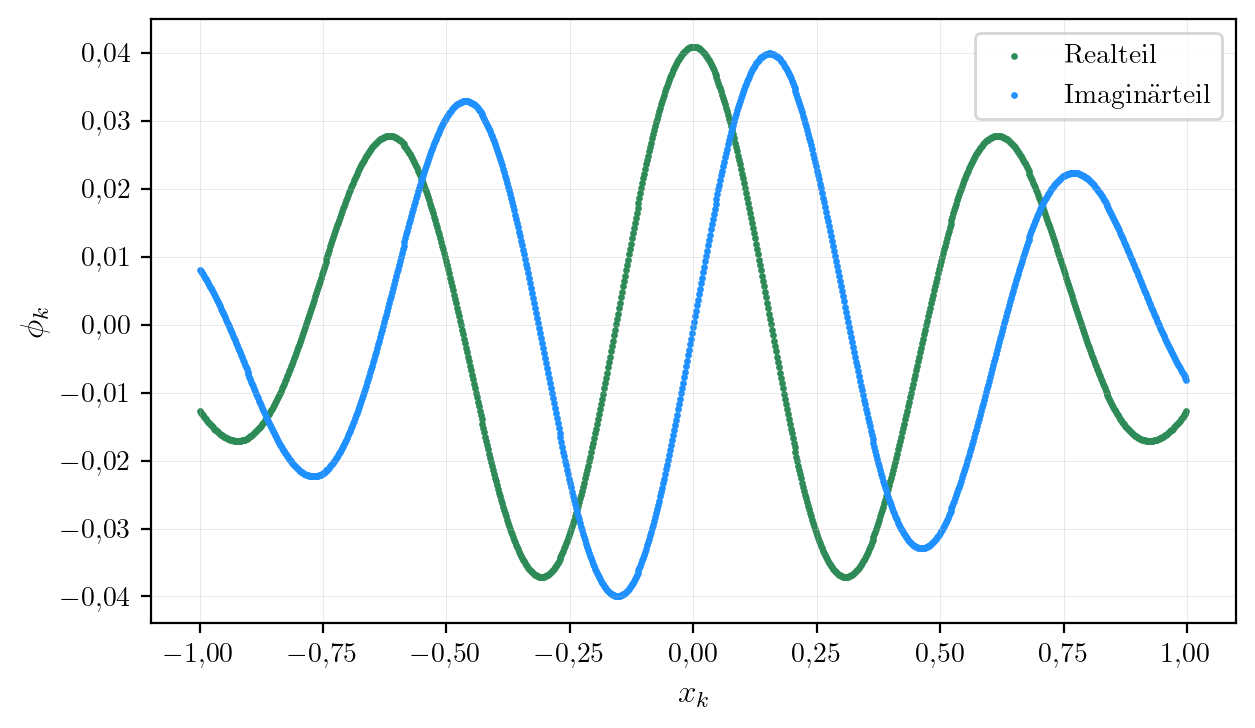

  0%|          | 0/4 [00:00<?, ?it/s]

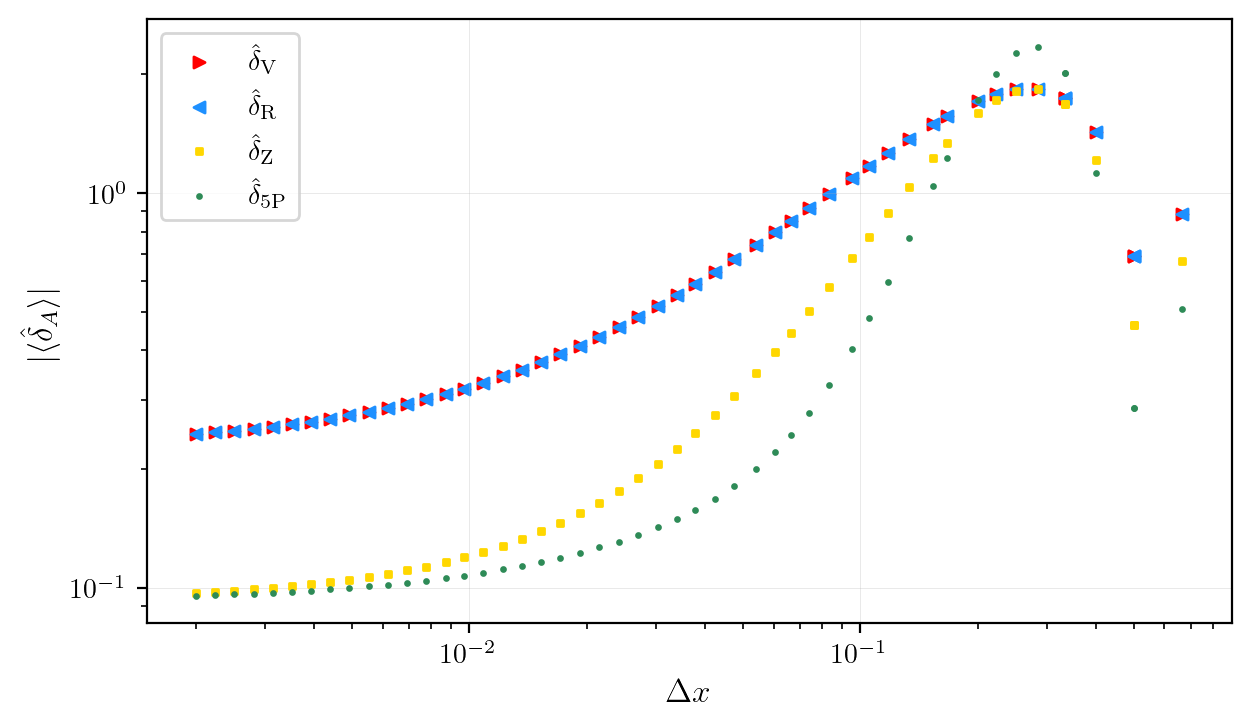

In [14]:
analyze_delta_ex_N_dependency_log(functools.partial(create_coherent_phi, omega=2, p=10), fit=False, filename="delta_ex_N_dependency_p10_omega_small_R1", R=1)

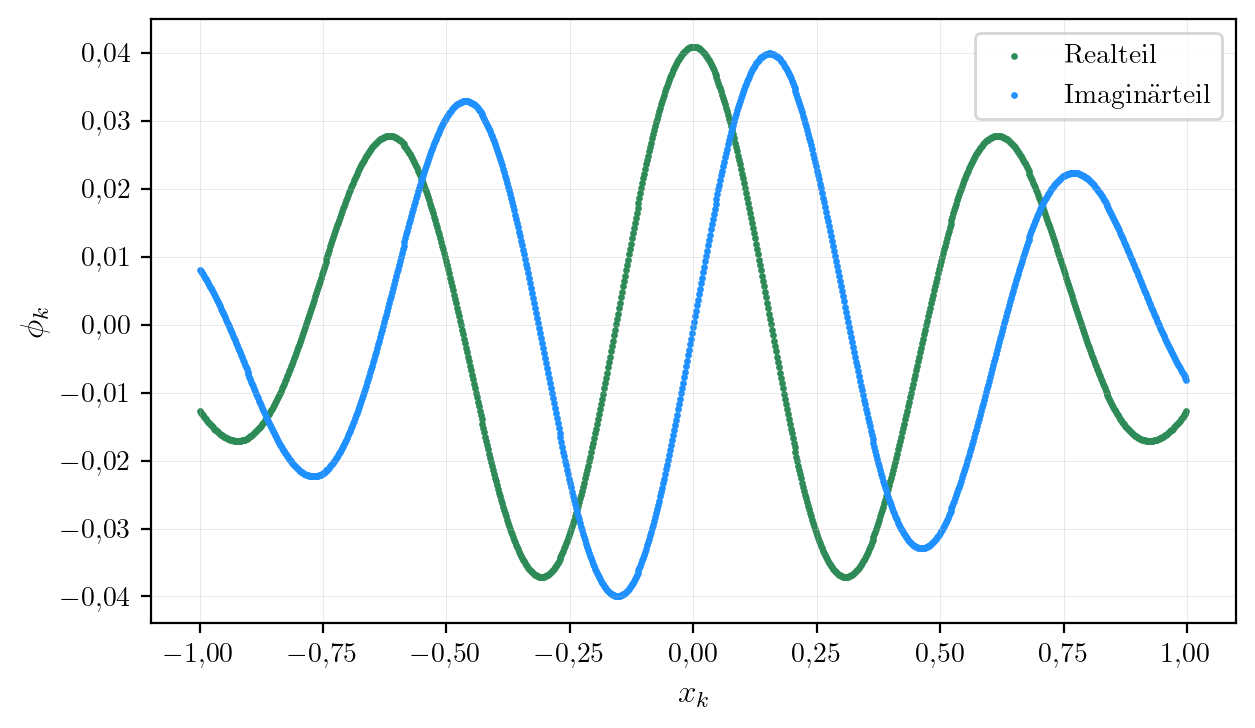

  0%|          | 0/4 [00:00<?, ?it/s]

chi_sq/dof = 1.0337550587686635e-07
chi_sq/dof = 1.0337550587662788e-07
chi_sq/dof = 0.0017315043857538237
chi_sq/dof = 0.0009290201902411785
Fit params (absolute):
  D_V:  alpha = 0,99902 +/- 0,00011,  beta = 2,2969 +/- 0,0006
  D_R:  alpha = 0,99902 +/- 0,00011,  beta = 2,2969 +/- 0,0006
  D_Z:  alpha = 1,72098 +/- 0,01328,  beta = 2,8574 +/- 0,0682
  D_5P:  alpha = 1,05877 +/- 0,00973,  beta = -2,2518 +/- 0,0499


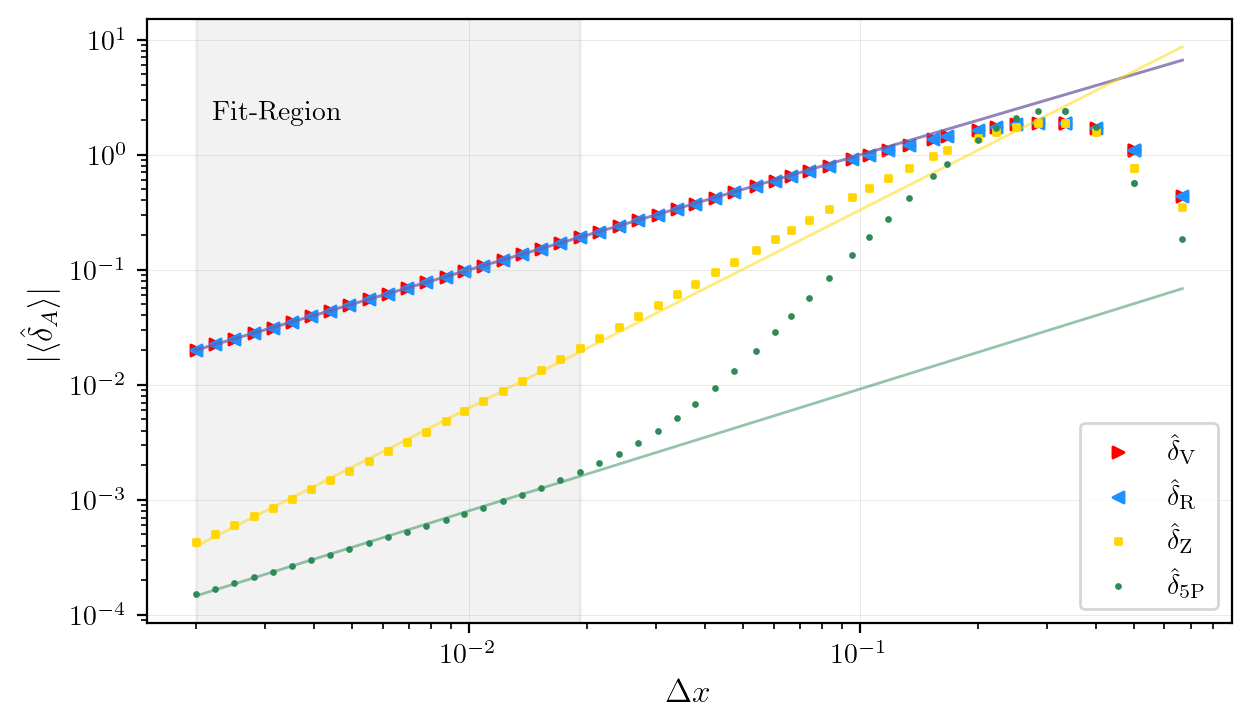

{'V': ((0.9990248791386841, 0.00010258542825329943),
  (2.2968747859391154, 0.0005263579606185516)),
 'R': ((0.9990248791386847, 0.0001025854282531707),
  (2.296874785939117, 0.000526357960617891)),
 'Z': ((1.7209753779208936, 0.013276654382050146),
  (2.8573958012855645, 0.0681214948688242)),
 '5P': ((1.058766090579981, 0.009724995928174093),
  (-2.2518202203540594, 0.049898207873522206))}

In [15]:
analyze_delta_ex_N_dependency_log(functools.partial(create_coherent_phi, omega=2, p=10), fit=True, filename="delta_ex_N_dependency_p10_omega_small_R0", R=0)

  0%|          | 0/3 [00:00<?, ?it/s]

V:
  R = 0:
    alpha0 = 0,9931 +/- 0,0002
  R = 1:
    alpha0 = 0,1388 +/- 0,0022
Z:
  R = 0:
    alpha0 = 1,6463 +/- 0,0041
  R = 1:
    alpha0 = 0,3173 +/- 0,0047
5P:
  R = 0:
    alpha0 = 1,1465 +/- 0,0069
  R = 1:
    alpha0 = 0,2251 +/- 0,0038


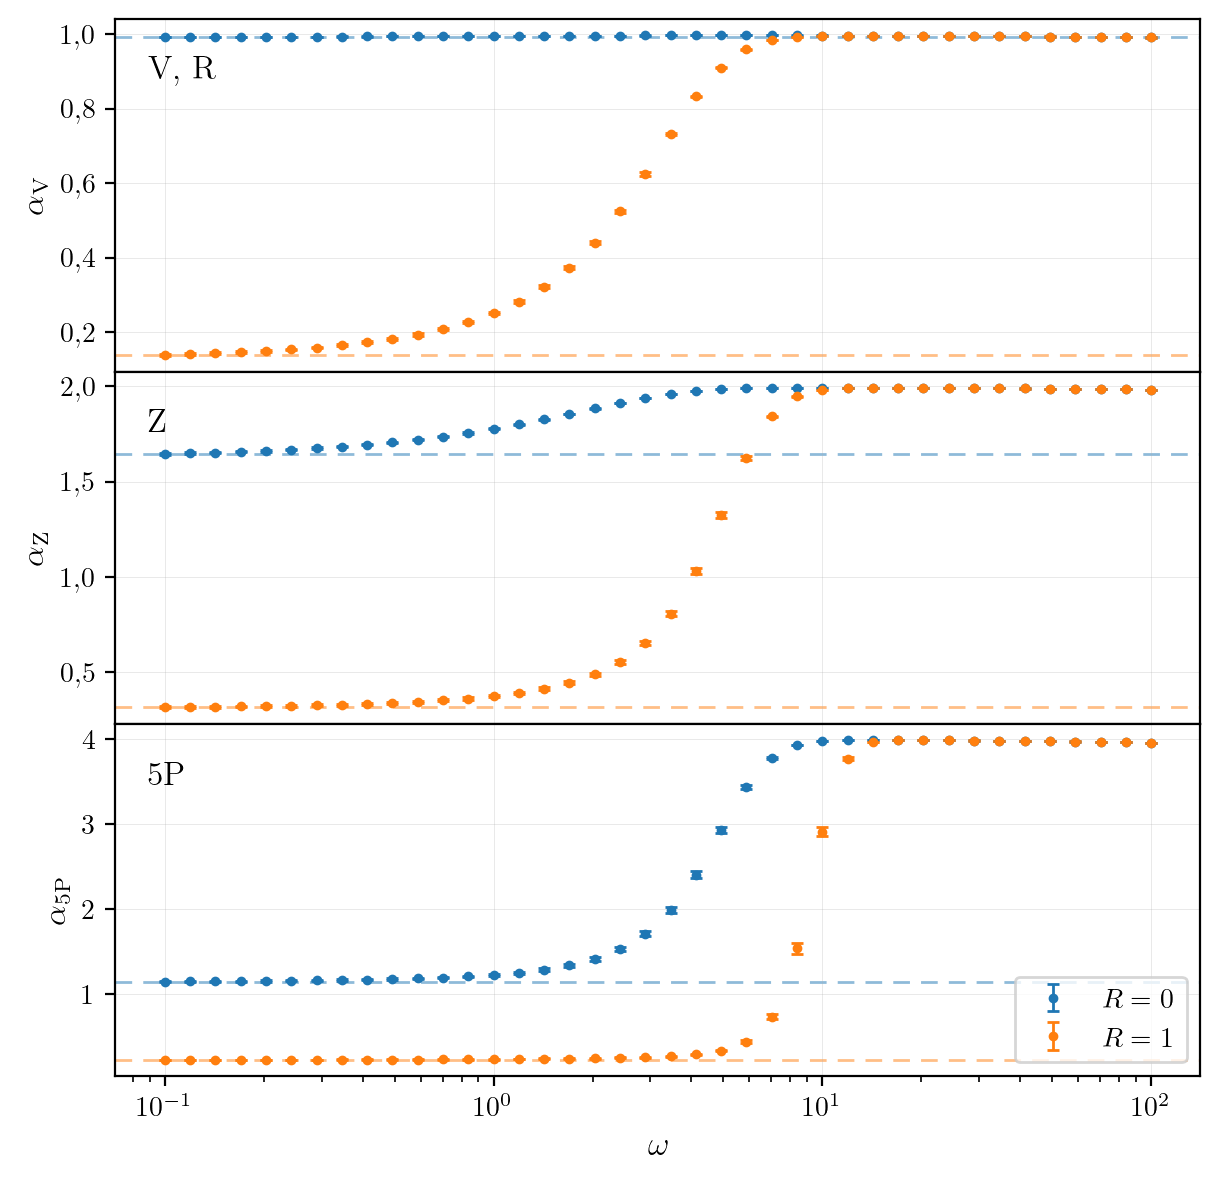

In [16]:
def analyze_delta_ex_order_R_dependency(p=10, q=0):
    omega_arr = np.logspace(-1, 2, 40)

    methods = ["V", "Z", "5P"]

    fig, axes = plt.subplots(len(methods), 1, figsize=(7, 7), sharex=True)

    for ax, method in zip(axes, tqdm(methods)):
        print(f"{method}:")
        for color, R in colorize([0, 1]):
            print(f"  R = {R}:")
            alphas = []
            alpha_errs = []

            for omega in omega_arr:
                fit_params = analyze_delta_ex_N_dependency_log(max_N=120, plot=False, progress=False,
                    create_phi=lambda N: create_coherent_phi(N, p=p, omega=omega, q=q), parts=[np.abs], R=R)

                alpha, alpha_err = fit_params[method][0]
                alphas.append(alpha)
                alpha_errs.append(alpha_err)

            alpha_arr = np.array(alphas)
            alpha_err_arr = np.array(alpha_errs)

            alpha0 = alpha_arr[0]
            alpha0_err = alpha_err_arr[0]

            ax.axhline(alpha0, color=color, linestyle="--", zorder=0, alpha=.5)

            print("    alpha0 =", fmt((alpha0, alpha0_err), 4))

            ax.errorbar(omega_arr, alpha_arr, yerr=alpha_err_arr, label=f"$R = {R}$", fmt=".", capsize=2, markersize=5, color=color)
        ax.set_ylabel("$\\alpha_\\mathrm{" + method + "}$")

        ax.text(0.03, 0.83, "V, R" if method == "V" else method, transform=ax.transAxes, size=12)

    plt.subplots_adjust(hspace=0)

    axes[-1].set_xlabel("$\\omega$")
    axes[-1].set_xscale("log")
    axes[-1].legend(loc="lower right")
    plt.savefig(f"output/analyze_delta_ex_order_R_dependency.pdf", bbox_inches="tight")
    plt.show()


analyze_delta_ex_order_R_dependency()

In [17]:
def plot_fit_params(x, params, *, xlabel=None, xscale="linear"):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    N = len(x)

    if (len(params) != N):
        raise ValueError(f"x and params must have the same length. Got {N} and {len(params)}.")

    for D_method in colorize_plots(D_methods):
        alphas = np.empty(N, np.complex128)
        betas = np.empty(N, np.complex128)
        for i in range(N):
            method_params = params[i][D_method]
            (alphas[i], _), (betas[i], _) = method_params

        kwargs = D_method_kwargs[D_method]
        ax1.scatter(x, alphas.real, label=D_method_label(D_method), **kwargs)
        ax1.plot(x, alphas.real, color=kwargs["color"], zorder=kwargs["zorder"], alpha=.2)
        ax2.scatter(x, betas.real, **kwargs)
        ax2.plot(x, betas.real, color=kwargs["color"], zorder=kwargs["zorder"], alpha=.2)

    ax1.set_ylabel("$\\alpha$")
    ax2.set_ylabel("$\\beta$")
    ax2.set_xlabel(xlabel)
    ax2.set_xscale(xscale)
    ax1.legend()
    plt.tight_layout()
    plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

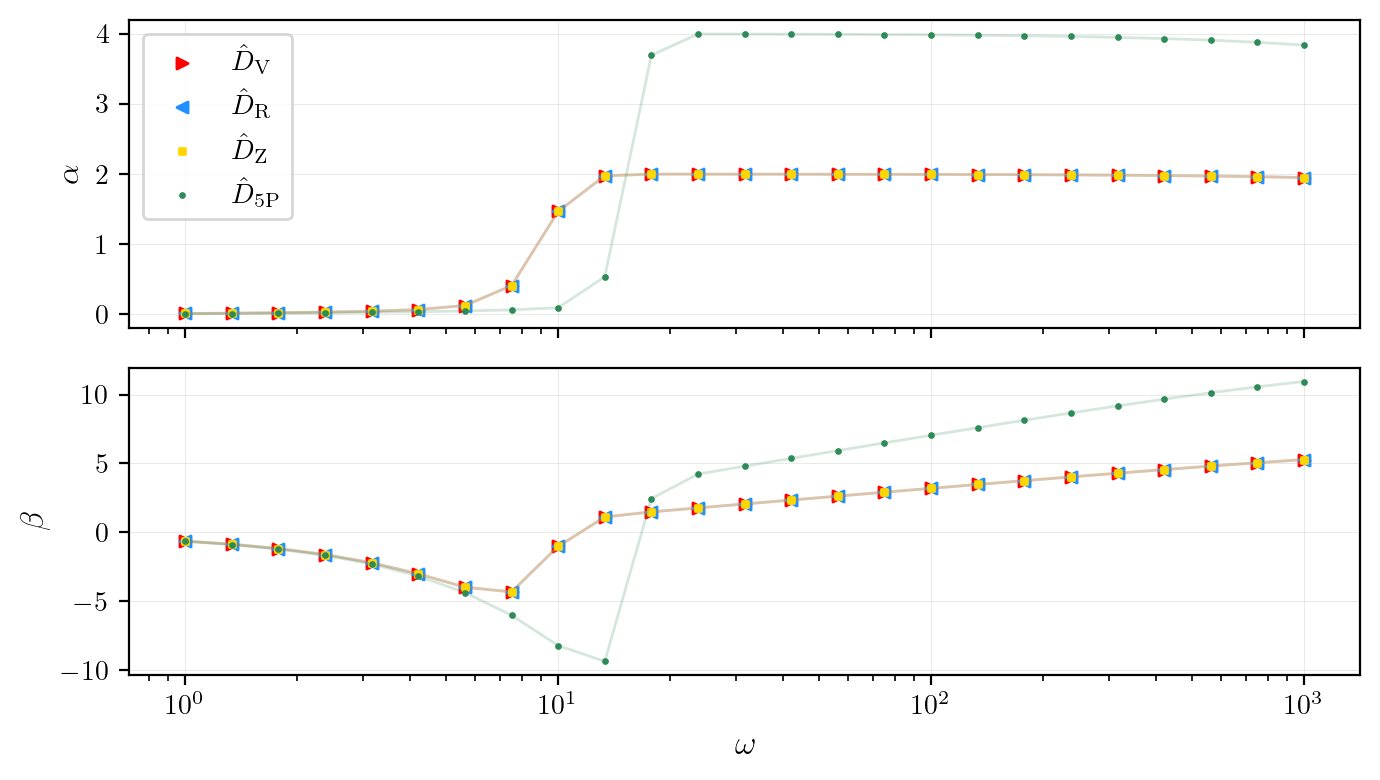

In [18]:
beauty: float = 5

omegas = np.logspace(0, 3, 5 * beauty)

params = [
    analyze_delta_ex_N_dependency_log(functools.partial(create_coherent_phi, omega=omega), plot=False, progress=False, max_N=200)
    for omega in tqdm(omegas)
]

plot_fit_params(omegas, params, xlabel="$\\omega$", xscale="log")

### Abhängigkeit vom Mittelwert

  0%|          | 0/25 [00:00<?, ?it/s]

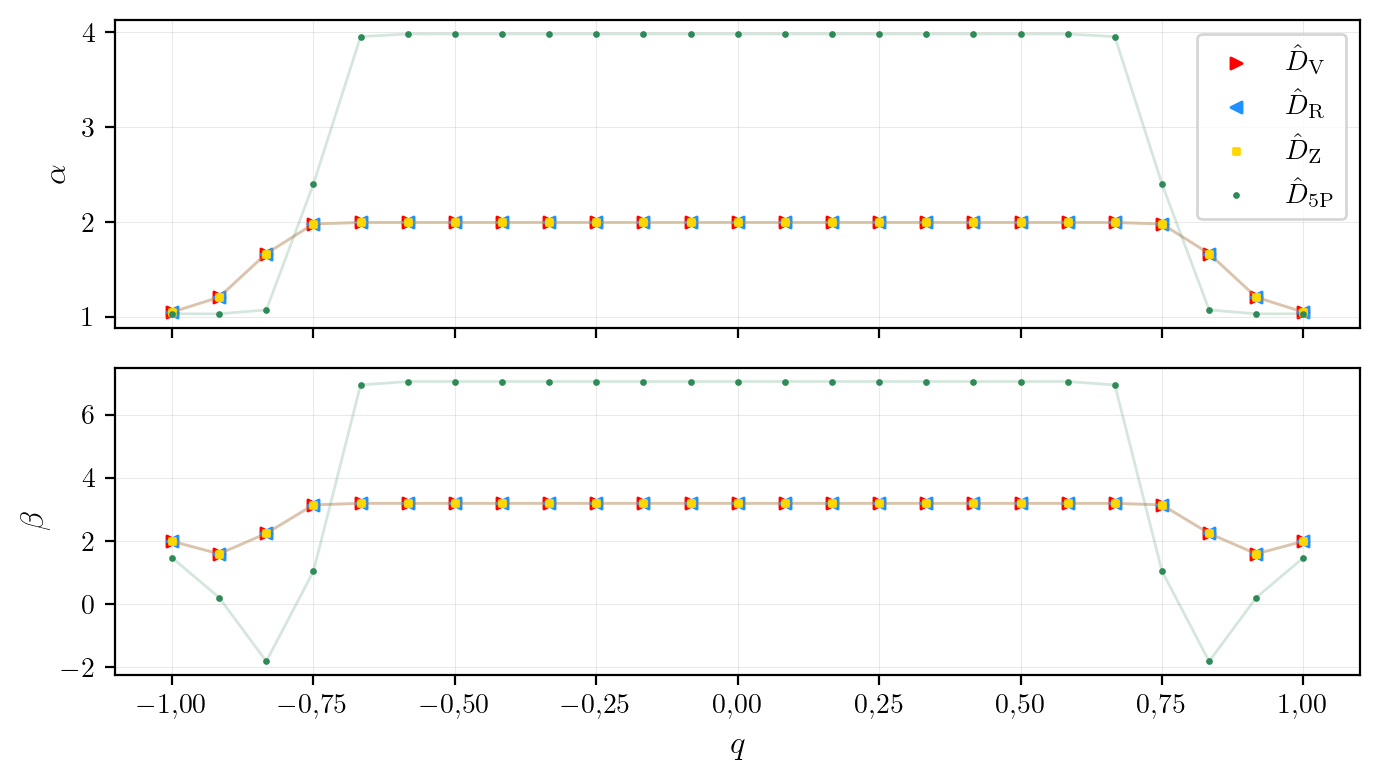

In [19]:
qs = np.linspace(-1, 1, 5 * beauty)

params = [
    analyze_delta_ex_N_dependency_log(functools.partial(create_coherent_phi, q=q), plot=False, progress=False, max_N=200)
    for q in tqdm(qs)
]

plot_fit_params(qs, params, xlabel="$q$")

# Eigenwerte

In [20]:
def undegenerate(eigvals, eigstates):
    undeg_eigvals = []
    undeg_eigstates_per_eigval = []

    for eigval, eigstate in zip(eigvals, eigstates):
        for i, (undeg_eigval, undeg_eigstates) in enumerate(zip(undeg_eigvals, undeg_eigstates_per_eigval)):
            if np.isclose(undeg_eigval, eigval):
                undeg_eigstates.append(eigstate)
                break
        else:
            undeg_eigvals.append(eigval)
            undeg_eigstates_per_eigval.append([eigstate])

    return undeg_eigvals, undeg_eigstates_per_eigval
            

def analyze_delta_eigvals(D_method, R=1, create_phi=lambda N: create_coherent_phi(N, omega=100), plot=True, progress=True):
    N_arr = np.logspace(.6, 2.6, 32, dtype=int)

    plt_x = []
    plt_y = []
    probs = []
    most_probable_deltas = []
    average_deltas = []
    exp_deltas = []

    delta_op = create_delta_op(D_method, R=R)

    for N in (tqdm(N_arr) if progress else N_arr):
        phi = create_phi(N)
        deg_eigvals, deg_eigstates = delta_op.eig(N)
        eigvals, eigstates_per_eigval = undegenerate(deg_eigvals, deg_eigstates)

        N_probs = []

        for eigval, eigstates in zip(eigvals, eigstates_per_eigval):
            plt_x.append(calc_dx(N).real)
            plt_y.append(eigval)

            state_probs = [np.abs(eigstate.conj().T @ phi) ** 2 for eigstate in eigstates]
            prob = sum(state_probs)
            # print(eigval, state_probs)
            N_probs.append(prob)
            
        probs.extend(N_probs)
        most_probable_deltas.append(eigvals[np.argmax(N_probs)])
        average_deltas.append(np.average(np.abs(eigvals), weights=N_probs))
        exp_deltas.append(delta_op.expval(phi))

    # Sort by probs
    sort_indices = np.argsort(probs)
    plt_x = np.array(plt_x)[sort_indices]
    plt_y = np.array(plt_y)[sort_indices]
    probs = np.array(probs)[sort_indices]

    most_probable_deltas = np.array(most_probable_deltas)
    average_deltas = np.array(average_deltas)
    exp_deltas = np.array(exp_deltas)

    if plot:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4, 3.5))

        cmap = "Blues"
        c = probs / (probs.max() - probs.min())
        kwargs = dict(marker="_", s=20, linewidths=.5, c=c, cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=1e-32, vmax=.1))

        s = ax1.scatter(plt_x, plt_y.real, **kwargs, label="Eigenwerte")
        # fig.colorbar(s, ax=[ax1, ax2])
        ax1.set_ylabel("$\\mathrm{Re}(\\delta_\\mathrm{" + D_method + "})$")
        ax1.set_ylim(-.5, 3)

        ax2.scatter(plt_x, plt_y.imag, **kwargs)
        ax2.set_xlabel("$\\Delta x$")
        ax2.set_xscale("log")
        ax2.set_ylabel("$\\mathrm{Im}(\\delta_\\mathrm{" + D_method + "})$")
        ax2.set_ylim(-1.8, 1.8)
        plt.subplots_adjust(hspace=0, right=.77)

        plt.savefig(f"output/delta_eigvals_{D_method}_R{R}.pdf", bbox_inches="tight")
        plt.show()

    return N_arr, average_deltas


$$
\delta_\mathrm{avg} := \frac{\sum_{k=0}^{N-1} |\braket{\delta_k | \psi}|^2 \cdot |\delta_k|}{\sum_{k=0}^{N-1} |\braket{\delta_k | \psi}|^2}
$$

  0%|          | 0/32 [00:00<?, ?it/s]

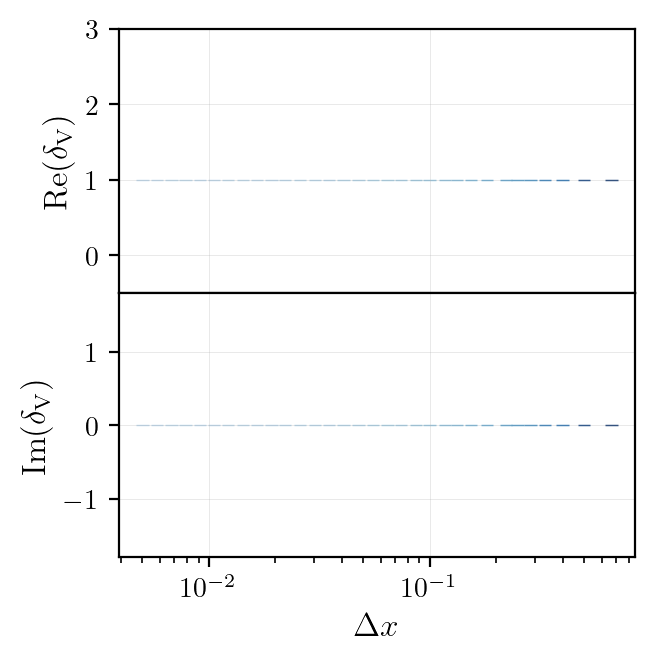

In [21]:
analyze_delta_eigvals("V", R=0); # Immer 0?

  0%|          | 0/32 [00:00<?, ?it/s]

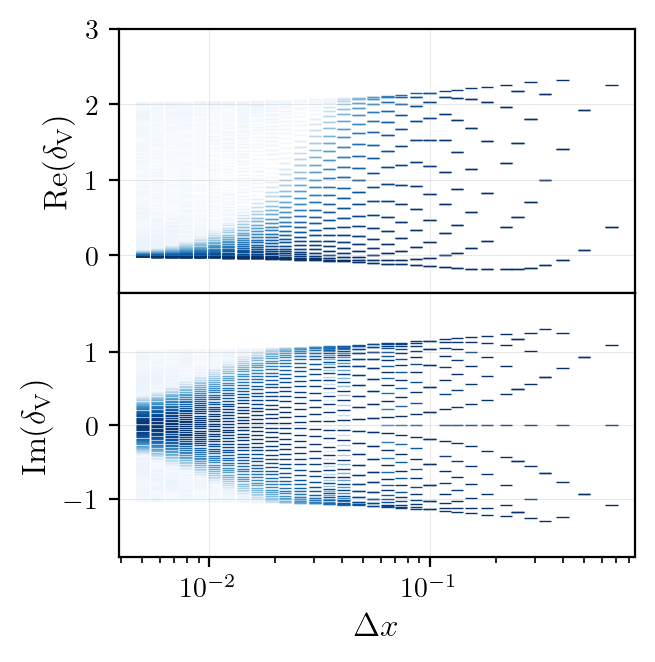

In [22]:
analyze_delta_eigvals("V", R=1);

  0%|          | 0/32 [00:00<?, ?it/s]

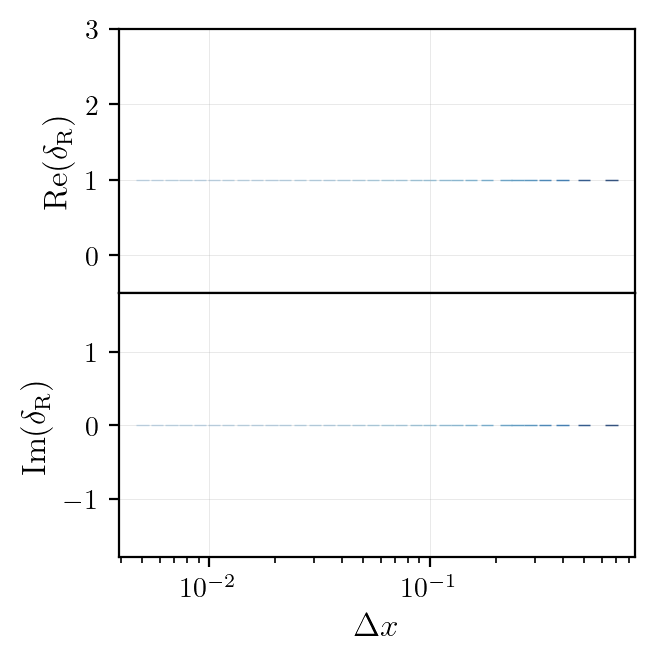

(array([  3,   4,   5,   6,   7,   8,   9,  11,  13,  15,  17,  20,  23,
         27,  31,  36,  42,  49,  57,  66,  77,  90, 104, 121, 140, 163,
        189, 219, 254, 295, 343, 398]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [23]:
analyze_delta_eigvals("R", R=0) # Auch immer 0

  0%|          | 0/32 [00:00<?, ?it/s]

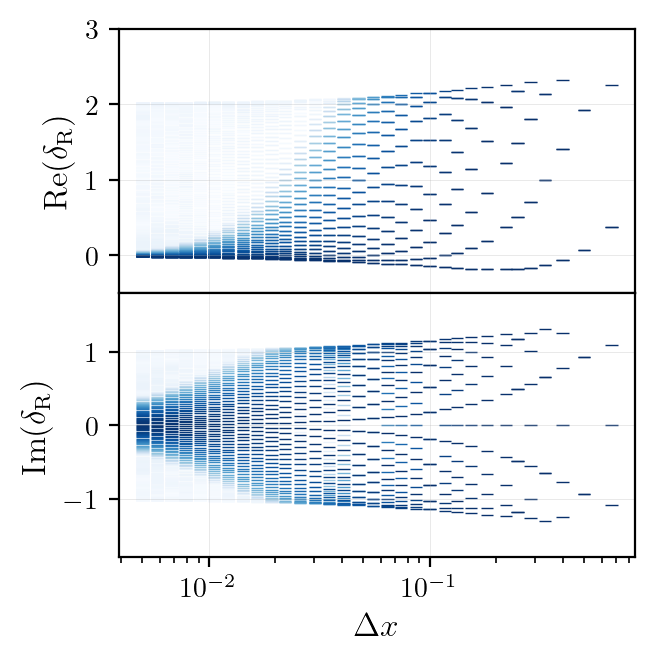

In [24]:
analyze_delta_eigvals("R", R=1);

  0%|          | 0/32 [00:00<?, ?it/s]

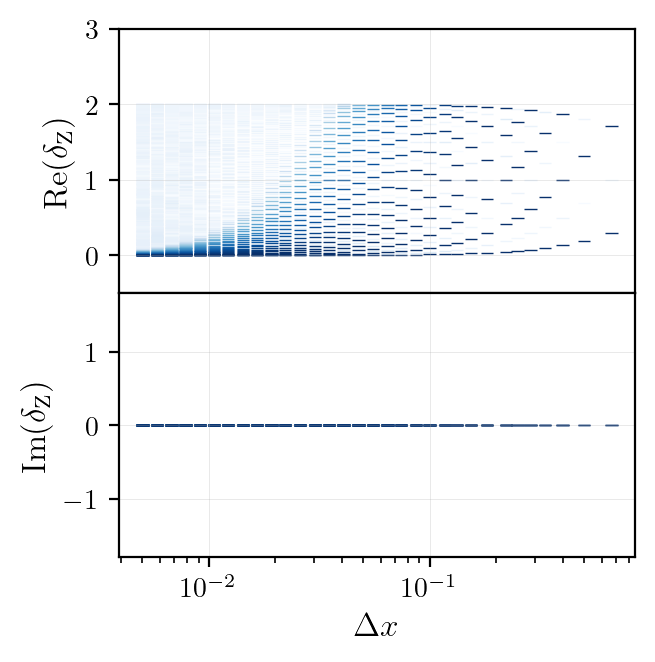

In [25]:
analyze_delta_eigvals("Z", R=0);

  0%|          | 0/32 [00:00<?, ?it/s]

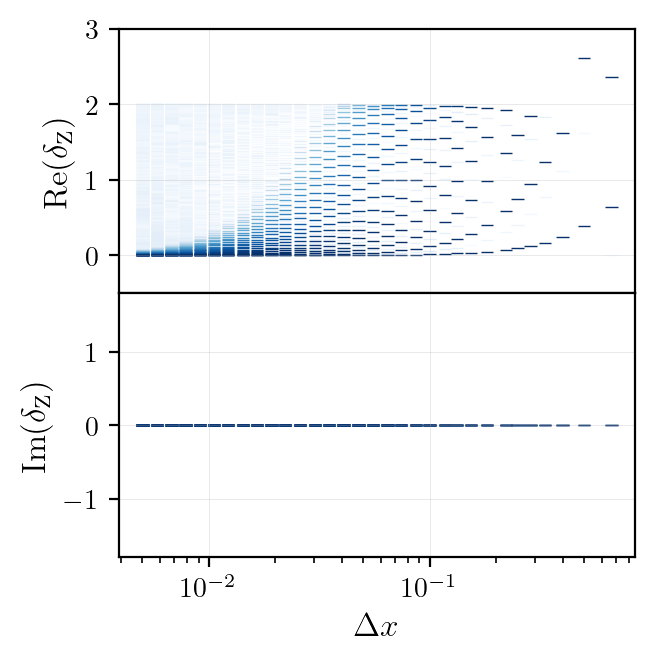

In [26]:
analyze_delta_eigvals("Z", R=1);

  0%|          | 0/32 [00:00<?, ?it/s]

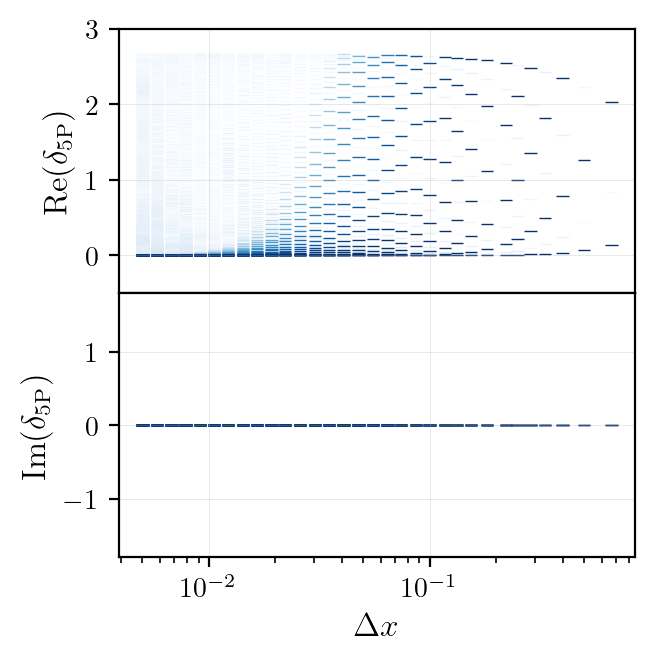

In [27]:
analyze_delta_eigvals("5P", R=0);

  0%|          | 0/32 [00:00<?, ?it/s]

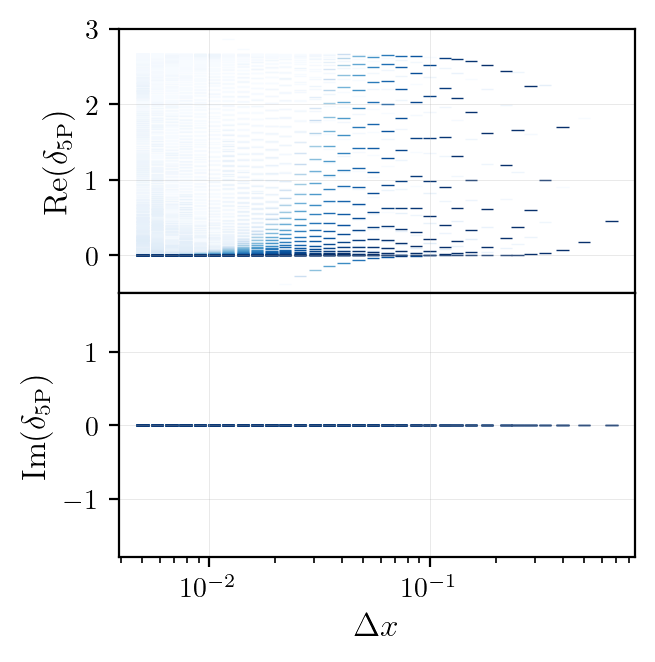

In [28]:
analyze_delta_eigvals("5P", R=1);

  0%|          | 0/4 [00:00<?, ?it/s]

V:
m = -0.9728948269904554, b = 2.4415838752602967
R:
m = -0.9728948269906079, b = 2.4415838752609353
Z:
m = -1.9898970613539653, b = 4.549296786042048
5P:
m = -3.9665163036182647, b = 9.718278012880088


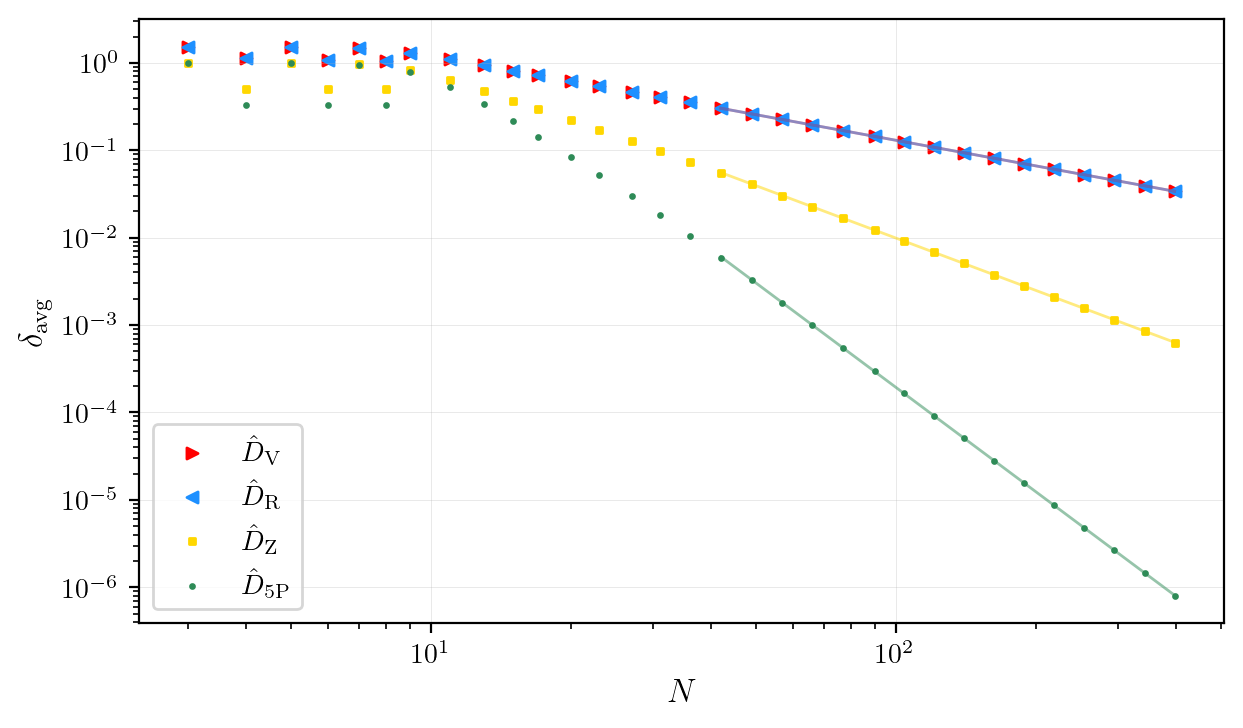

In [29]:
def analyze_delta_eigvals_for_all_methods(R=1, create_phi=create_coherent_phi):
    for D_method in tqdm(D_methods):
        print(D_method + ":")
        kwargs = D_method_kwargs[D_method]
        N_arr, average_deltas = analyze_delta_eigvals(D_method, R=R, plot=False, progress=False, create_phi=create_phi)

        plt.scatter(N_arr, np.abs(average_deltas), label=D_method_label(D_method), **kwargs)
        # ax3.scatter(N_arr, np.abs(exp_deltas), s=2, c="k", alpha=.3, label="$\\langle \\hat \\delta_\\mathrm{" + D_method + "} \\rangle$")

        fit_N_count = 16
        fit_x = N_arr[-fit_N_count:]
        fit_y = np.abs(average_deltas[-fit_N_count:])

        m, b = np.polyfit(np.log(fit_x), np.log(fit_y), 1)
        fit_func_y = np.exp(b) * fit_x ** m

        print(f"m = {m}, b = {b}")

        plt.plot(fit_x, fit_func_y, color=kwargs["color"], alpha=.5)
            
    plt.xlabel("$N$")
    plt.ylabel("$\\delta_\\mathrm{avg}$")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.show()

analyze_delta_eigvals_for_all_methods()

  0%|          | 0/4 [00:00<?, ?it/s]

V:
m = 0.0, b = 0.0
R:
m = 0.0, b = 0.0
Z:
m = -1.98989706135408, b = 4.549296786042471
5P:
m = -3.966516301544258, b = 9.718278001939348


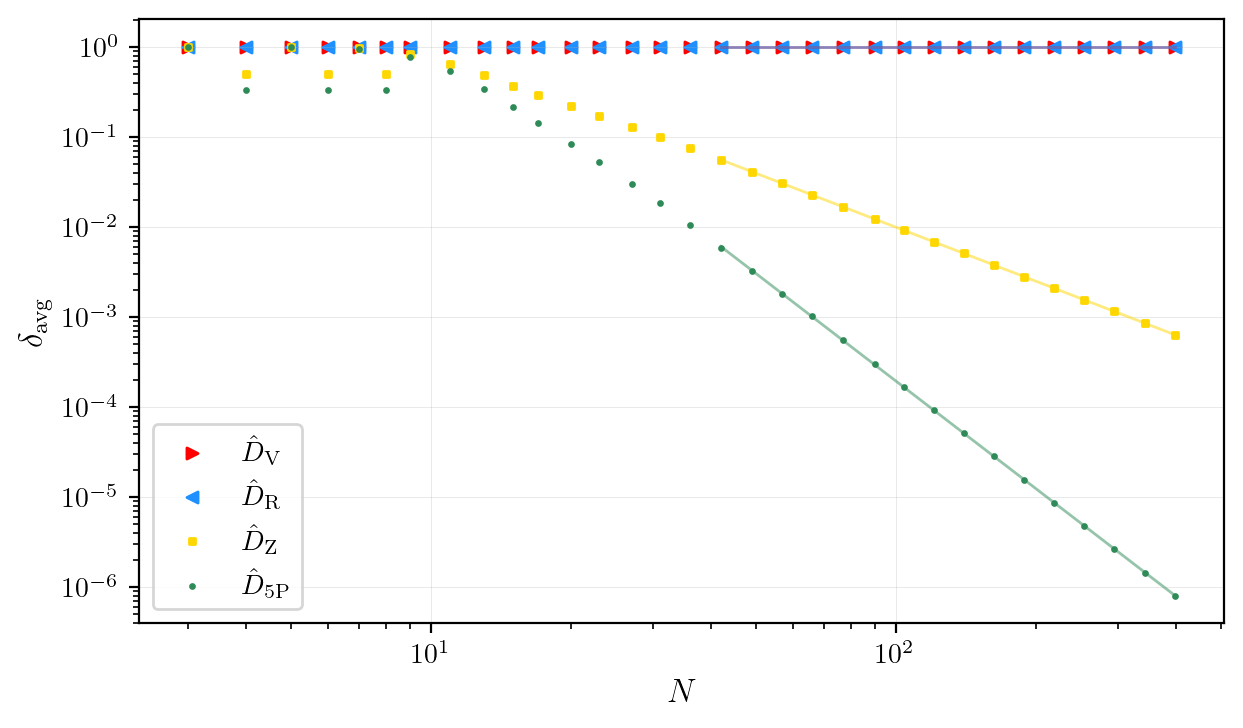

In [30]:
analyze_delta_eigvals_for_all_methods(R=0)